In [51]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
import string
from nltk import word_tokenize, FreqDist
from sklearn.naive_bayes import ComplementNB

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, plot_confusion_matrix

# import warnings
# warnings.filterwarnings('ignore')

In [2]:
raw_data = pd.read_csv('data/judge-1377884607_tweet_product_company.csv', encoding = 'latin1')
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
tweet_text                                            9092 non-null object
emotion_in_tweet_is_directed_at                       3291 non-null object
is_there_an_emotion_directed_at_a_brand_or_product    9093 non-null object
dtypes: object(3)
memory usage: 213.2+ KB


In [3]:
# theres's only one null in the tweet text column
raw_data = raw_data.drop(index=6, axis=0)
raw_data.head(10)

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion
5,@teachntech00 New iPad Apps For #SpeechTherapy...,NaN,No emotion toward brand or product
7,"#SXSW is just starting, #CTIA is around the co...",Android,Positive emotion
8,Beautifully smart and simple idea RT @madebyma...,iPad or iPhone App,Positive emotion
9,Counting down the days to #sxsw plus strong Ca...,Apple,Positive emotion
10,Excited to meet the @samsungmobileus at #sxsw ...,Android,Positive emotion


## Data Exploration and Cleaning

Taking a look at the subjects of the tweets, I can see they are labeled with several subcategories of Google and Apple products. 

In [4]:
raw_data['emotion_in_tweet_is_directed_at'].value_counts()

iPad                               946
Apple                              661
iPad or iPhone App                 470
Google                             430
iPhone                             297
Other Google product or service    293
Android App                         81
Android                             78
Other Apple product or service      35
Name: emotion_in_tweet_is_directed_at, dtype: int64

In [5]:
raw_data['emotion_in_tweet_is_directed_at'].isna().sum()

5801

And looking at the sentiment, it looks like most of these are labeled as neutral and there are actually very few negative tweets. I assume this is because the tweets are from product announcements at SXSW, so the atmosphere is focused on excitement or news around new product launches. 

In [6]:
raw_data['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()

No emotion toward brand or product    5388
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: int64

I want to take a closer look at the 'I can't tell' category to see if I can group it in with neutral or if I should disregard. 

In [7]:
ct_df = raw_data[raw_data['is_there_an_emotion_directed_at_a_brand_or_product'] == 'I can\'t tell']
ct_df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
90,Thanks to @mention for publishing the news of ...,NaN,I can't tell
102,ÛÏ@mention &quot;Apple has opened a pop-up st...,NaN,I can't tell
237,Just what America needs. RT @mention Google to...,NaN,I can't tell
341,The queue at the Apple Store in Austin is FOUR...,NaN,I can't tell
368,Hope it's better than wave RT @mention Buzz is...,NaN,I can't tell


So there's tweets not in english, some tweets that look actually neutral, and some like the one I've selected below maybe are sarcastic (below) but even I, a human, am not sure if I would actually categorize this as negative. It seems unrealistic to go through all of these and it also doesn't make sense to have an 'idk' class so I'm going to relabel them as neutral along with the no emotion tweets.

In [8]:
ct_df.loc[237][0]

'Just what America needs. RT @mention Google to Launch Major New Social Network Called Circles, Possibly Today {link} #sxsw'

I also want to preview the neutral tweets... and they look pretty neutral. So I'm going to create a new classifier column to sort these into: 0 for negative, 1 for positive, 2 neutral. 

In [9]:
ne_df = raw_data[raw_data['is_there_an_emotion_directed_at_a_brand_or_product'] == 'No emotion toward brand or product']
ne_df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
5,@teachntech00 New iPad Apps For #SpeechTherapy...,NaN,No emotion toward brand or product
16,Holler Gram for iPad on the iTunes App Store -...,NaN,No emotion toward brand or product
32,"Attn: All #SXSW frineds, @mention Register fo...",NaN,No emotion toward brand or product
33,Anyone at #sxsw want to sell their old iPad?,NaN,No emotion toward brand or product
34,Anyone at #SXSW who bought the new iPad want ...,NaN,No emotion toward brand or product


In [10]:
#creating a new column for multiclass problem
raw_data['class'] = 0
for row in raw_data.index:
    if raw_data['is_there_an_emotion_directed_at_a_brand_or_product'][row] == 'Positive emotion':
        raw_data['class'][row] = 1
    elif raw_data['is_there_an_emotion_directed_at_a_brand_or_product'][row] == 'No emotion toward brand or product':
        raw_data['class'][row] = 2
    elif raw_data['is_there_an_emotion_directed_at_a_brand_or_product'][row] == 'I can\'t tell':
        raw_data['class'][row] = 2
        
raw_data.head(10)

C:\Users\christina.sarver\Anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\christina.sarver\Anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\christina.sarver\Anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __na

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product,class
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,0
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,1
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,1
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,0
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,1
5,@teachntech00 New iPad Apps For #SpeechTherapy...,NaN,No emotion toward brand or product,2
7,"#SXSW is just starting, #CTIA is around the co...",Android,Positive emotion,1
8,Beautifully smart and simple idea RT @madebyma...,iPad or iPhone App,Positive emotion,1
9,Counting down the days to #sxsw plus strong Ca...,Apple,Positive emotion,1
10,Excited to meet the @samsungmobileus at #sxsw ...,Android,Positive emotion,1


The classes are pretty imbalanced. This could become a problem when working through the modeling so I will keep this in mind. 

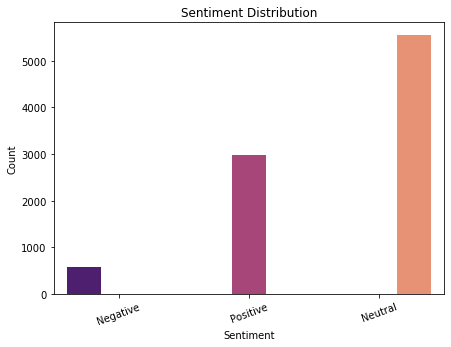

In [11]:
plt.figure (figsize=(7,5))
ax = sns.countplot(x = 'class', hue = 'class', data = raw_data, palette = 'magma')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks([0, 1, 2], ['Negative', 'Positive', 'Neutral'], rotation=20)
ax.get_legend().remove()

plt.show()

#update this to add products or change chart?

Another problem is that the data is missing a lot of labels. When I look at the nulls, I can actually see a lot of the product mentions in them so I'm going to see if I can classify a few more.

In [12]:
nulls_df = raw_data[raw_data['emotion_in_tweet_is_directed_at'].isna()]

print('There are', len(nulls_df), 'unlabeled tweets out of', len(raw_data),
      'total which equates to', round(len(nulls_df)/len(raw_data)*100,2), "%")

There are 5801 unlabeled tweets out of 9092 total which equates to 63.8 %


In [13]:
nulls_df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product,class
5,@teachntech00 New iPad Apps For #SpeechTherapy...,NaN,No emotion toward brand or product,2
16,Holler Gram for iPad on the iTunes App Store -...,NaN,No emotion toward brand or product,2
32,"Attn: All #SXSW frineds, @mention Register fo...",NaN,No emotion toward brand or product,2
33,Anyone at #sxsw want to sell their old iPad?,NaN,No emotion toward brand or product,2
34,Anyone at #SXSW who bought the new iPad want ...,NaN,No emotion toward brand or product,2


Most of the unlabeled tweets are neutral anyway so they really don't have a lot of info. 

In [14]:
nulls_df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()

No emotion toward brand or product    5297
Positive emotion                       306
I can't tell                           147
Negative emotion                        51
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: int64

However, from the above preview I can clearly see brand/product mentions so I'm going to go through this and search for both Apple and Google related terms.

In [15]:
apple_searchwords = ['iPad','iTunes','Apple', 'apple', 'iPhone', 'macbook']

apple = nulls_df[nulls_df['tweet_text'].str.findall('^(?:'+'|'.join(apple_searchwords) + ')').apply(len) > 0].fillna('Apple')

apple.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product,class
78,iPad2? RT @mention Droid &amp; Mac here :) RT ...,Apple,No emotion toward brand or product,2
194,Apple has 200M users' credit cards sync'd with...,Apple,No emotion toward brand or product,2
222,Apple has a temporary Retail Store in Austin f...,Apple,No emotion toward brand or product,2
230,Apple IIe ad in the '85 SI swimsuit issue at a...,Apple,No emotion toward brand or product,2
254,iPad 2 vs Android vs The World : Panel at #SXS...,Apple,No emotion toward brand or product,2


Of course, this doesn't work perfectly as with the below example but it's an efficient method. 

In [16]:
nulls_df.loc[65][0]

'Agree. RT @mention Wait. FIONA APPLE is in town??? Somebody kidnap her and put her in a recording studio until she records a new album. #sxsw'

In [17]:
google_searchwords = ['android','Google','android']

google = nulls_df[nulls_df['tweet_text'].str.findall('^(?:'+'|'.join(google_searchwords) + ')').apply(len) > 0].fillna("Google")
google.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product,class
256,Google is announcing a social network &quot;Ci...,Google,No emotion toward brand or product,2
397,Google to Circle Austin? #sxsw {link},Google,No emotion toward brand or product,2
422,Google to debut new selective social network t...,Google,No emotion toward brand or product,2
542,Google to give social networking another try w...,Google,No emotion toward brand or product,2
623,Google to Host Developer Day at SXSW {link} #s...,Google,No emotion toward brand or product,2


In [18]:
apple_indexes = list(apple.index)
google_indexes = list(google.index)

In [19]:
# if raw_data.index is in apple_indexes:
#     raw_data['emotion_in_tweet_is_directed_at'].fillna('Apple')

These mostly look correct though and I've added 430 new labels to the data. 

In [20]:
# binary indicator
# for value in raw_data['emotion_in_tweet_is_directed_at']:
#     if value == 'iPad' or 'Apple' or'iPad or iPhone App' or 'iPhone' or 'Other Apple product or service':
#         raw_data['apple'] = 1
        
# for value in raw_data['emotion_in_tweet_is_directed_at']:
#     if value == 'Google' or 'Android App' or'Android' or 'Other Google product or service':
#         raw_data['google'] = 1    

In [21]:
grouped_negative = raw_data[raw_data['class'] == 0].groupby('emotion_in_tweet_is_directed_at').count()
grouped_negative = grouped_negative.drop(columns=['tweet_text', 'is_there_an_emotion_directed_at_a_brand_or_product'])

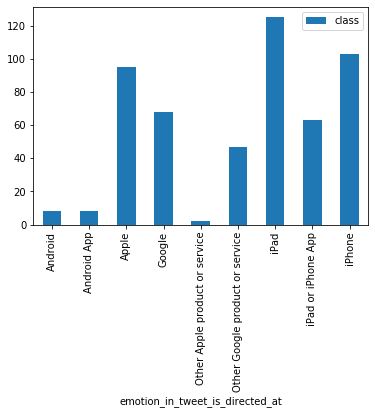

In [22]:
grouped_negative.plot(kind='bar', stacked=True)

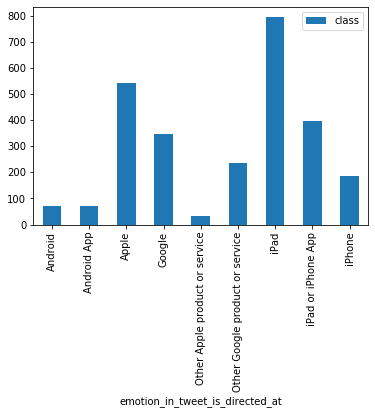

In [23]:
grouped_positive = raw_data[raw_data['class'] == 1].groupby('emotion_in_tweet_is_directed_at').count()
grouped_positive = grouped_positive.drop(columns=['tweet_text', 'is_there_an_emotion_directed_at_a_brand_or_product'])
grouped_positive.plot(kind='bar', stacked=True)

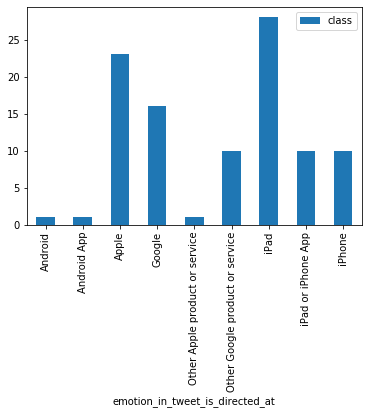

In [24]:
grouped_neutral = raw_data[raw_data['class'] == 2].groupby('emotion_in_tweet_is_directed_at').count()
grouped_neutral = grouped_neutral.drop(columns=['tweet_text', 'is_there_an_emotion_directed_at_a_brand_or_product'])
grouped_neutral.plot(kind='bar', stacked=True)

In [60]:
raw_data['class'].value_counts(normalize=True)

2    0.609767
1    0.327541
0    0.062692
Name: class, dtype: float64

## Preprocessing

In [25]:
stopwords_list = stopwords.words('english')
stopwords_list += string.punctuation
punct_list = ["''", '""', '...', '``']
stopwords_list += punct_list

In [26]:
def process_tweet(tweet):
    tokens = nltk.word_tokenize(tweet)
    words_lower = [token.lower() for token in tokens]
    words_stopped = [word for word in words_lower if word not in stopwords_list]
    return words_stopped

In [27]:
processed_data = list(map(process_tweet, raw_data['tweet_text']))

In [28]:
processed_data[0]

['wesley83',
 '3g',
 'iphone',
 '3',
 'hrs',
 'tweeting',
 'rise_austin',
 'dead',
 'need',
 'upgrade',
 'plugin',
 'stations',
 'sxsw']

In [29]:
total_vocab = set()
for token in processed_data:
    total_vocab.update(token)
    
print(len(total_vocab))

10630


In [30]:
tweet_concat = []
for tweet in processed_data:
    tweet_concat += tweet
    
tweet_freqdist = FreqDist(tweet_concat)
tweet_freqdist.most_common(2000)

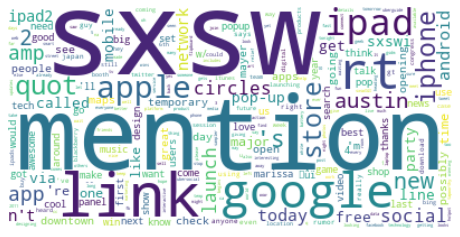

In [32]:
from wordcloud import WordCloud

wc = WordCloud(background_color="white", max_words=2000)
wc.generate_from_frequencies(tweet_freqdist)

plt.figure(figsize=(8,8))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.margins(x=1, y=1)
plt.show()

In [ ]:
# use regex to remove @handles?

## Modeling

### Multinomial Naive Bayes

In [37]:
X = raw_data['tweet_text']
y = raw_data['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10)

In [47]:
count_vectorizer = CountVectorizer(stop_words=stopwords_list)

X_train_count = count_vectorizer.fit_transform(X_train)
X_test_count = count_vectorizer.transform(X_test)

In [62]:
nb_classifier = MultinomialNB()

nb_classifier.fit(X_train_count, y_train)

train_preds = nb_classifier.predict(X_train_count)
test_preds = nb_classifier.predict(X_test_count)

TypeError: fit() got an unexpected keyword argument 'class_weight'

0.6924769027716674


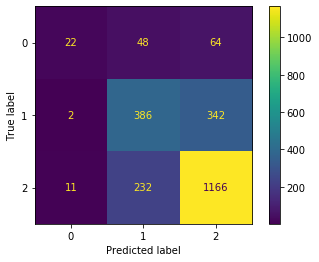

In [49]:
print(accuracy_score(y_test, test_preds))

plot_confusion_matrix(nb_classifier, X_test_count, y_test)

### TF-IDF

In [52]:
tfidf = TfidfVectorizer(stop_words=stopwords_list, 
                        max_df = .95, # removes words that appear in more than 95% of docs
                        min_df = 2, # removes words that appear 2 or fewer times
                        use_idf=True)

tfidf_train = tfidf.fit_transform(X_train)
tfidf_test = tfidf.transform(X_test)

In [53]:
tfidf_test_df = pd.DataFrame(tfidf_test.toarray(), columns=tfidf.get_feature_names())

In [54]:
# Grabbing that row once it's been vectorized
test_doc = tfidf_test_df.iloc[22]

print(test_doc.loc[test_doc > 0].sort_values(ascending=False)) # Showing values > 0

rt          0.456580
mention     0.330658
possibly    0.314477
major       0.299616
called      0.288671
network     0.270569
today       0.257225
social      0.249115
circles     0.248551
launch      0.247991
new         0.214361
google      0.157421
link        0.121504
Name: 22, dtype: float64


In [79]:
nb_tfidf = MultinomialNB()

nb_tfidf.fit(tfidf_train, y_train)

train_preds = nb_tfidf.predict(tfidf_train)
test_preds = nb_tfidf.predict(tfidf_test)

0.6810382754069512


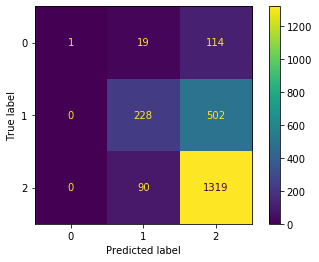

In [80]:
print(accuracy_score(y_test, test_preds))

plot_confusion_matrix(nb_tfidf, tfidf_test, y_test)

### Complement Naive Bayes

Suited for imbalanced datasets

https://towardsdatascience.com/comparing-a-variety-of-naive-bayes-classification-algorithms-fc5fa298379e

In [81]:
cnb = ComplementNB()
cnb.fit(tfidf_train, y_train)

ComplementNB()

In [82]:
train_preds = cnb.predict(tfidf_train)
test_preds = cnb.predict(tfidf_test)

0.6621205455345358


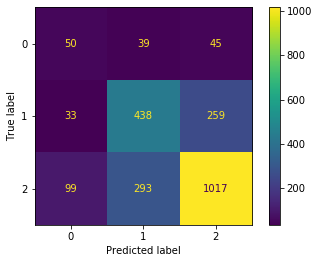

In [83]:
print(accuracy_score(y_test, test_preds))

plot_confusion_matrix(cnb, tfidf_test, y_test)